# Experiment with multiple system scores

\demo \label{trivial2}. We use one random pair of human scores. We show that for the same set of human scores PRMSE will not change the system rankings when compared to MSE. \AL{Not sure if we want to go into other metrics here since the rankings might differ}.

\demo \label{mA2H}. We repeat experiment \ref{1A2H} but now we use different systems and evaluate them on different pairs of raters. We (hope to) show that PRMSE will give us more stable rankings than other metrics. 


In [263]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import itertools
import numpy as np

import json

from rsmtool.prmse_utils import compute_prmse
%matplotlib inline

In [264]:
df = pd.read_csv('../data/data.csv')
config = json.load(open('settings.json'))
N_responses = config['N_responses']
N_raters = config['N_raters']
N_systems = config['N_systems']

## Trivial. 

Let's first look at a pair of raters and how are systems compare.

In [265]:
human = ['h_5', 'h_2']
df['human'] = df[human].mean(axis=1)
h_corr = pearsonr(df[human[0]], df[human[1]])[0]

In [266]:
system_columns = ['sys_{}'.format(i) for i in range(1, N_systems+1)]

In [275]:
df_true = df[system_columns].corrwith(df['true'])
df_human = df[system_columns].corrwith(df['human'])
df_corr = pd.concat([df_true, df_human], axis=1)
df_corr.columns=['corr_true', 'corr_human']

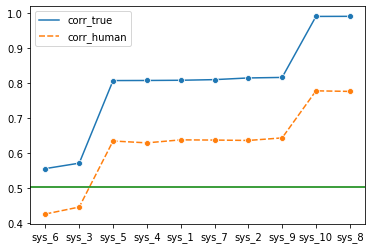

In [277]:
ax=sns.lineplot(data=df_corr.sort_values(by='corr_true'), sort=False, marker='o')
ax.axhline(h_corr, color='green')

In [269]:
# r2 for individual systems
r2_systems= []
for s in system_columns:
    r2_systems.append(r2_score(df['human'], df[s]))
r2_systems = pd.Series(r2_systems, index=system_columns, name='r2_human')

In [270]:
# r2 with true score for individual systems
r2_true= []
for s in system_columns:
    r2_true.append(r2_score(df['true'], df[s]))
r2_true = pd.Series(r2_true, index=system_columns, name='r2_true')

In [271]:
# prmse for individual systemsp
df_prmse = compute_prmse(df, system_score_columns=system_columns,
                         h1_column=human[0],
                         h2_column=human[1])

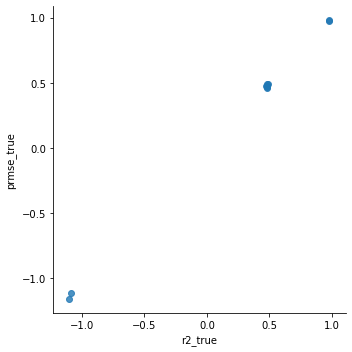

In [272]:
# show how prmse relates to r2_true
sns.lmplot(x='r2_true', y='prmse_true', data=df_r2, fit_reg=False)

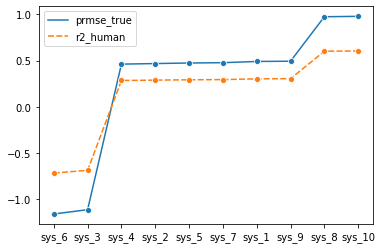

In [288]:
df_r2 = pd.concat([df_prmse, r2_systems, r2_true, df_corr], axis=1)
df_r2.sort_values(by='prmse_true', inplace=True)
ax=sns.lineplot(data=df_r2[['prmse_true', 'r2_human']], sort=False, marker='o')
#ax2 = ax.twinx()
#sns.lineplot(data=df_r2['corr_human'], ax=ax2, color="r", marker='o', sort=False)

## Compare different system on different pairs

In [242]:
# generate all possible pairs of raters
raters = ['h_{}'.format(h) for h in range(1, N_raters+1)]
# we do the following to keep the array unidimensional
rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]

In [243]:
# randomly sample pairs for each system
N_pairs = N_systems
np.random.seed(14436323)
selected_pairs = np.random.choice(rater_pairs, N_pairs, replace=False)

In [244]:
out = []
for i in range(N_systems):
    humans = selected_pairs[i].split('+')
    system = system_columns[i]
    mean = df[humans].mean(axis=1)
    corr = pearsonr(df[system], mean)[0]
    corr_human =  pearsonr(df[humans[0]], df[humans[1]])[0]
    r2 = r2_score(mean, df[system])
    r2_true = r2_score(df['true'], df[system])
    prmse = compute_prmse(df, system_score_columns=system, h1_column=human[0], h2_column=human[1])['prmse_true'].values
    res = pd.DataFrame({'humans': selected_pairs[i],
                       'corr': corr,
                        'corr_human': corr_human,
                       'r2_observed': r2,
                        'r2_true': r2_true,
                       'prmse': prmse},
                       index=[system])
    out.append(res)
df_res = pd.concat(out)

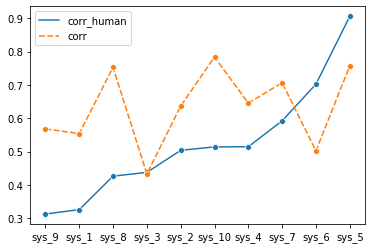

In [245]:
sns.lineplot(data=df_res[['corr_human', 'corr']].sort_values('corr_human'), sort=False, marker='o')

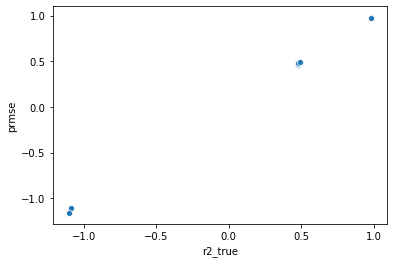

In [246]:
sns.scatterplot(x='r2_true', y='prmse', data=df_res)

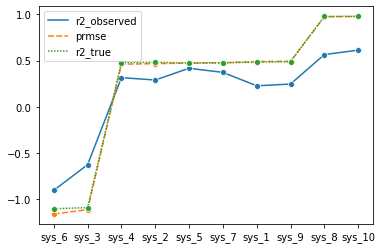

In [247]:
sns.lineplot(data=df_res[['r2_observed', 'prmse', 'r2_true']].sort_values('prmse'), marker='o', sort=False)

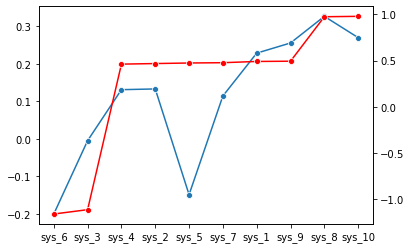

In [248]:
# could we get the same through degradation
df_res['delta'] = df_res['corr'] - df_res['corr_human']
df_res.sort_values('prmse', inplace=True)
ax = sns.lineplot(data=df_res['delta'], sort=False, marker='o')
ax2 = ax.twinx()
sns.lineplot(data=df_res['prmse'], ax=ax2, color="r", marker='o', sort=False)

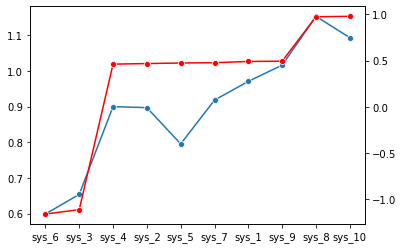

In [249]:
# could we get the same through disattenuated correlation?
df_res['dis_corr'] = df_res['corr']/np.sqrt(df_res['corr_human'])
df_res.sort_values('prmse', inplace=True)
ax = sns.lineplot(data=df_res['dis_corr'], sort=False, marker='o')
ax2 = ax.twinx()
sns.lineplot(data=df_res['prmse'], ax=ax2, color="r", marker='o', sort=False)